# Demographics for Transit Oriented Communities entitlements

Let's take a close look at entitlement applications for Transit Oriented Communities (TOC).

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.utils

import laplan

cat = intake.open_catalog("../catalogs/*.yml")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


First, we load a bunch of relevant data.

In [2]:
# Census tracts
tracts = cat.census_tracts.read()

# Crosswalk from parcels to tracts
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

# ACS data for income, race, commute, tenure
census = cat.census_analysis_table.read()

In [3]:
pcts = cat.pcts2.read()
pcts = laplan.pcts.subset_pcts(pcts, get_dummies=True, suffix_list=["TOC"], verbose=True)
pcts = laplan.pcts.drop_child_cases(pcts, keep_child_entitlements=True)

Parsing PCTS case numbers
2146 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'HPO', 'CPC', 'AA', 'APCSV', 'CHC', 'APCH', 'APCE', 'APCNV', 'ENV', 'TT', 'APCW', 'APCC', 'VTT', 'ZA', 'PS', 'APCS'}


In [4]:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN", "TOC_Tier"]],
    how="left",
    on="AIN",
)

Get all of the tracts for which more than 50% of the parcels fall within one TOC tier.
Consider those tracts to be TOC tracts.

In [5]:
toc_eligible_tracts = parcel_to_tract.groupby("GEOID").agg({
    "TOC_Tier": lambda x: True if sum(x > 0)/len(x) >= 0.5 else False
})

Plot up the TOC-eligible tracts:

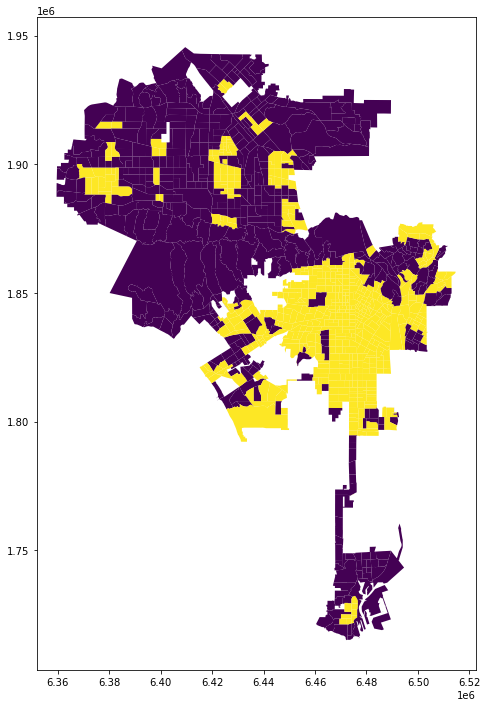

In [6]:
tracts.merge(
    toc_eligible_tracts,
    left_on="GEOID10",
    right_index=True
).plot(column="TOC_Tier", figsize=(12,12))

Let's count the number of TOC entitlements per tract:

In [7]:
toc_count = pcts.dropna(subset=["GEOID"]).groupby(["CASE_ID"]).agg({
    "TOC": "first",
    "GEOID": lambda x: x.value_counts().index[0],
}).reset_index().groupby("GEOID").agg({
  "TOC": "count"  
})

In [8]:
joined = pandas.merge(
    census.set_index("GEOID"),
    toc_eligible_tracts,
    how="left",
    left_index=True,
    right_index=True,
).merge(
    toc_count,
    how="left",
    left_index=True,
    right_index=True,
).fillna({"TOC": 0}).dropna()

In [9]:
joined = geopandas.GeoDataFrame(joined, geometry=tracts.set_index("GEOID10").geometry)

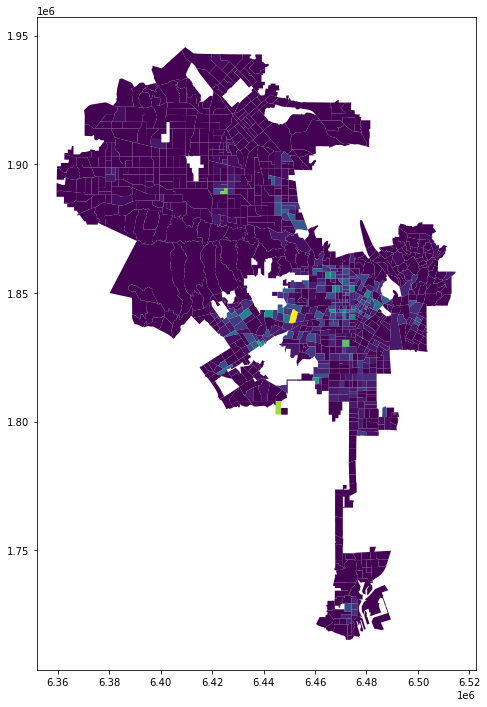

In [10]:
joined.plot(column="TOC", figsize=(12,12))

## Demographics of TOC tracts

Let's investigate the demographic differences between TOC tracts and non-toc tracts.

In order to do so in a population-normalized way, we have to use population totals rather than percentages.

In [11]:
non_toc_pop = joined.groupby("TOC_Tier")["pop_total"].sum()[False]
toc_pop = joined.groupby("TOC_Tier")["pop_total"].sum()[True]
income_cols = [c for c in joined.columns if c.startswith("total_")]
demo_cols = [
    "non_car_workers",
    "zero_veh_workers",
    "pop_renter",
    "pop_whitenonhisp",
]
toc_pop_totals = joined.groupby("TOC_Tier")[[
    "pop_total",
    *demo_cols,
    *income_cols,
]].sum().astype("float")

In [12]:
toc_pop_totals.loc[False, demo_cols] = (
    toc_pop_totals.loc[False, demo_cols] / 
    toc_pop_totals.loc[False, "pop_total"]
)
toc_pop_totals.loc[True, demo_cols] = (
    toc_pop_totals.loc[True, demo_cols] / 
    toc_pop_totals.loc[True, "pop_total"]
)

In [13]:
toc_pop_totals.loc[False, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[False],
        [50],
    )[0]
)
toc_pop_totals.loc[True, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[True],
        [50],
    )[0]
)

In [14]:
toc_pop_totals[demo_cols + ["medhhincome"]].T.style.format("{:.2n}")

TOC_Tier,False,True
non_car_workers,0.037,0.095
zero_veh_workers,0.014,0.046
pop_renter,0.45,0.72
pop_whitenonhisp,0.38,0.22
medhhincome,74,48


## Modeling TOC entitlements

Let's use a Random Forest regressor as a baseline model for relating TOC permits to
demographic and zoning data. These models tend to do very well at fitting data and are simple to create.

In [15]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
]
target = "TOC"

In [16]:
to_fit = joined.dropna()[variables + [target, "TOC_Tier", "geometry"]]

Let's visualize the spatial distribution of these variables to check that they make sense:

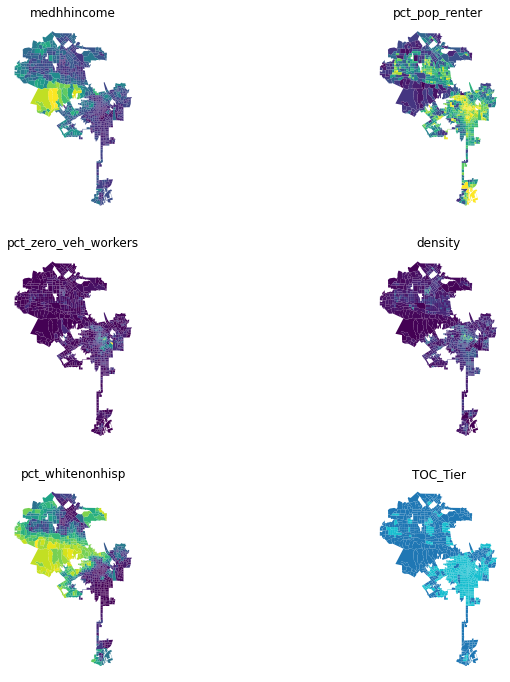

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))
for i, var in enumerate(variables + ["TOC_Tier"]):
    ax = axes.ravel()[i]
    to_fit.plot(ax=ax, column=var)
    ax.axis("off")
    ax.set_title(var)

In [18]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor()),
])

In [19]:
def plot_model(predictions):
    vmin=None
    vmax=None
    fig, axes = plt.subplots(1,2, figsize=(16, 16))
    axes[0].axis("off")
    axes[0].set_title("Actual Number of TOC")
    (tracts
     .set_index("GEOID10")
     .assign(TOC=to_fit.TOC)
     .fillna({"TOC": 0})
     .plot(ax=axes[0],column="TOC", vmax=vmax, vmin=vmin)
    )
    axes[1].axis("off")
    axes[1].set_title("Predicted number of TOC")
    (tracts
     .set_index("GEOID10")
     .assign(predictions=pandas.Series(predictions, index=to_fit.index))
     .fillna({"predictions": 0})
     .plot(ax=axes[1],column="predictions", vmax=vmax, vmin=vmin)
    )
    plt.close(fig)
    return fig

In [20]:
to_fit = to_fit[to_fit.TOC_Tier == True]

Plot up the model to see how it does:

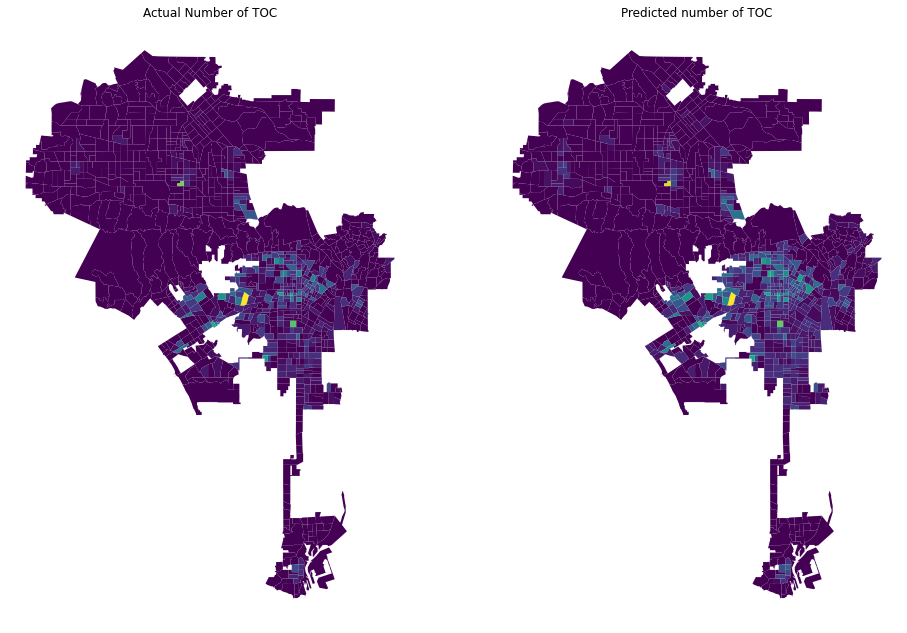

In [21]:
np.random.seed(1)

random_forest_model.fit(to_fit[variables], to_fit[target])
plot_model(random_forest_model.predict(to_fit[variables]))

In [22]:
pandas.Series(random_forest_model["regressor"].feature_importances_, index=variables)

medhhincome             0.187629
pct_pop_renter          0.244680
pct_zero_veh_workers    0.167154
density                 0.206352
pct_whitenonhisp        0.194184
dtype: float64

Looks like it still does an acceptable job of predicing where the entitlements will be.
Unfortunately, random forest regression has a major drawback: it is difficult to interpret.
There is not a strong meaning we can attach to the decision tree splits,
and due to its ensemble nature, it is difficult to visualize.

We can instead try to fit the same data to a model with a strong backing process:
Poisson linear regression. In this model, the number of TOC entitlements are
modeled as a Poisson process, where the underlying rate is a log-linear function
of our features.


In [23]:
poisson_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, tol=1.e-6))
])

In [24]:
np.random.seed(1)

def sample_poisson_model(data, target, norm=1): 
    def get_coefs(model):
        return model["regressor"].coef_
    
    samples = np.array([
        get_coefs(
            poisson_model.fit(
                *sklearn.utils.resample(
                    data,
                    (target/norm).replace([np.nan, np.inf], 0.0),
                )
            )
        )
        for i in range(1000)
    ])
    return samples

In [25]:
samples = sample_poisson_model(to_fit[variables], to_fit[target])

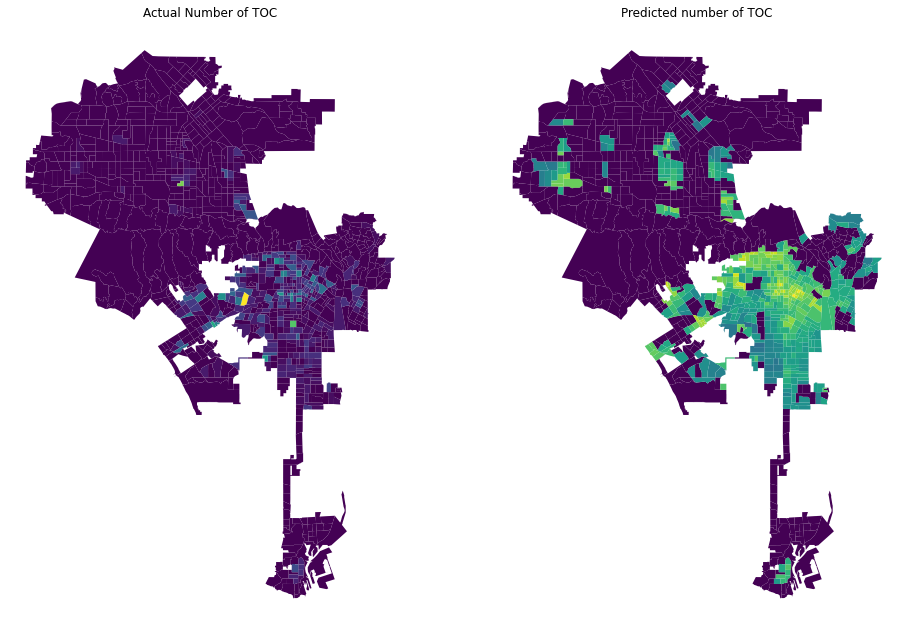

In [26]:
poisson_model.fit(to_fit[variables], to_fit[target])
plot_model(poisson_model.predict(to_fit[variables]))

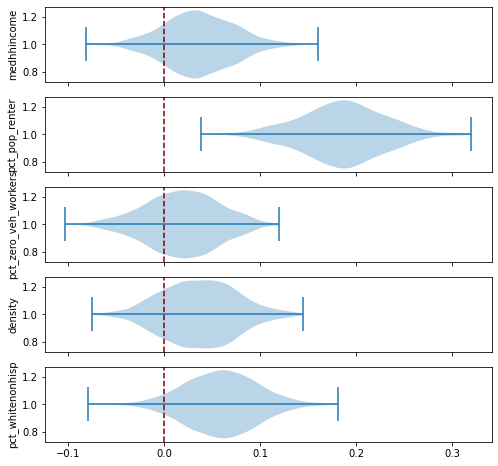

In [27]:
fig, axes = plt.subplots(
    len(variables),
    1,
    sharex=True,
    sharey=True,
    figsize=(8,8),

)

for i, var in enumerate(variables):
    ax = axes[i]
    ax.violinplot(samples[:,i], vert=False)
    ax.set_ylabel(var)
    ax.axvline(0, color="maroon", ls="--")

#### Interpreting the coefficients

In [28]:
scaler = poisson_model["scaler"]
regressor = poisson_model["regressor"]

In [29]:
beta = pandas.Series(regressor.coef_/scaler.scale_, index=variables)
alpha = regressor.intercept_ - np.dot(scaler.mean_ , beta)

In [30]:
import IPython.display

In [31]:
scale = 10000
val = (np.exp(beta[0]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every ${scale:,} increase in median household income, "
    f"there is a {val:.1f}% increase in TOC entitlements"
))
scale = 0.1
val = (np.exp(beta[1]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of renters, "
    f"there is a {val:.1f}% increase in TOC entitlements"
))
scale = 0.1
val = (np.exp(beta[2]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of zero-vehicle workers, "
    f"there is a {val:.1f}% increase in TOC entitlements"
))
scale = 1000
val = (np.exp(beta[3]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} people/km increase in population density, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))
scale = 0.1
val = (np.exp(beta[4]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of white non-Hispanic residents, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))

For every $10,000 increase in median household income, there is a 1.5% increase in TOC entitlements

For every 10% increase in population of renters, there is a 9.3% increase in TOC entitlements

For every 10% increase in population of zero-vehicle workers, there is a 2.2% increase in TOC entitlements

For every 1,000 people/km increase in population density, there is a 0.3% increase in CUB entitlements

For every 10% increase in population of white non-Hispanic residents, there is a 2.5% increase in CUB entitlements